In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
import os

# Configure settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# 1. Data Processing

## 1.1 Loading data and handling missing value

In [81]:
# Load raw data
df_raw = pd.read_csv('../data/raw/hourly_data.csv')
df_raw.drop(columns='Unnamed: 0', inplace=True)
df_raw['datetime'] = pd.to_datetime(df_raw['datetime'])
     
print("RAW DATA OVERVIEW:")
print(f"Shape: {df_raw.shape}")
print(f"Date range: {df_raw['datetime'].min()} to {df_raw['datetime'].max()}")

# Check data types and missing values
print(f"\nDATA QUALITY CHECK:")
print(f"Missing values per column:")
missing_summary = df_raw.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]
remove_columns_name = []
if len(missing_summary) > 0:
    for col, count in missing_summary.items():
        pct = (count / len(df_raw)) * 100
        print(f"  {col}: {count} ({pct:.1f}%)")
        if pct >= 95:
            remove_columns_name.append(col)
    if remove_columns_name:
        df_raw.drop(columns=remove_columns_name, inplace=True)
else:
    print("No missing values found!")
print(f'Deleted columns missing 90%: {remove_columns_name}')

print(f"\nDuplicate records: {df_raw.duplicated().sum()}")

# Change the datatype of datetime column to datetime
df_raw['datetime'] = pd.to_datetime(df_raw['datetime']) 

# Data information
print(f"\nDATA TYPES:")
print(df_raw.info())


RAW DATA OVERVIEW:
Shape: (85705, 33)
Date range: 2015-10-01 00:00:00 to 2025-10-01 23:00:00

DATA QUALITY CHECK:
Missing values per column:
  datetime: 1 (0.0%)
  precip: 37 (0.0%)
  preciptype: 78357 (91.4%)
  snow: 41 (0.0%)
  snowdepth: 41 (0.0%)
  windgust: 48 (0.1%)
  windspeed: 1 (0.0%)
  winddir: 2 (0.0%)
  visibility: 203 (0.2%)
  solarradiation: 36 (0.0%)
  solarenergy: 36 (0.0%)
  uvindex: 36 (0.0%)
  severerisk: 81025 (94.5%)
  tempmax: 85704 (100.0%)
  tempmin: 85704 (100.0%)
  feelslikemax: 85704 (100.0%)
  feelslikemin: 85704 (100.0%)
  precipcover: 85704 (100.0%)
  sunrise: 85704 (100.0%)
  sunset: 85704 (100.0%)
  moonphase: 85704 (100.0%)
  description: 85704 (100.0%)
Deleted columns missing 90%: ['tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'precipcover', 'sunrise', 'sunset', 'moonphase', 'description']

Duplicate records: 0

DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85705 entries, 0 to 85704
Data columns (total 24 columns):
 #   Column  

### 1.1.1 Handling missing datetime data

In [82]:
mask = df_raw['datetime'].isna()
df_raw[mask]

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
35520,Hanoi,NaT,22.4,22.4,20.0,86.3,3.145,100,rain,0.0,0.0,25.6,25.0,29.4,1012.9,91.9,9.6,42.3,3.7,2.0,NaN,"Rain, Overcast",rain,"48820099999,48823099999,48825099999,4883109999..."


In [83]:
df_raw[35519:35522]

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
35519,Hanoi,2019-11-30 23:00:00,22.0,22.0,18.0,78.06,0.000,0,NaN,0.0,0.0,6.8,9.4,105.0,1017.0,50.0,8.0,0.0,0.0,0.0,NaN,Partially cloudy,partly-cloudy-night,"48820099999,VVNB"
35520,Hanoi,NaT,22.4,22.4,20.0,86.30,3.145,100,rain,0.0,0.0,25.6,25.0,29.4,1012.9,91.9,9.6,42.3,3.7,2.0,NaN,"Rain, Overcast",rain,"48820099999,48823099999,48825099999,4883109999..."
35521,Hanoi,2019-12-01 00:00:00,22.0,22.0,18.0,78.06,0.000,0,NaN,0.0,0.0,7.6,6.5,55.0,1017.0,70.0,6.5,0.0,0.0,0.0,NaN,Partially cloudy,partly-cloudy-night,"48820099999,VVNB"


In [84]:
df_raw.drop(labels=35520, axis=0, inplace=True) #Deleting redundant row

In [85]:
df_raw.set_index('datetime', inplace=True)

### 1.1.2 Handling missing precip data

In [86]:
# precip column
print("PRECIP ANALYSIS:")
print("Value counts:")
print(f"NaN values: {df_raw['precip'].isnull().sum()}")
df_raw['precip'].fillna(0, inplace=True)
print(f"\nAFTER PROCESSING:")
print(f"NaN values: {df_raw['precip'].isnull().sum()}")

PRECIP ANALYSIS:
Value counts:
NaN values: 37

AFTER PROCESSING:
NaN values: 0


### 1.1.3 Handling missing preciptype data

In [87]:
# preciptype column
print("PRECIPTYPE ANALYSIS:")
print("Value counts:")
print(df_raw['preciptype'].value_counts())
print(f"NaN values: {df_raw['preciptype'].isnull().sum()}")

# Check relationship with precipitation amount
print(f"\nCross-check with precip amount:")
print("When preciptype is NaN:")
no_preciptype = df_raw[df_raw['preciptype'].isnull()]
print(f"  - Average precip: {no_preciptype['precip'].mean():.3f} mm")
print(f"  - Max precip: {no_preciptype['precip'].max():.3f} mm")
print(f"  - Days with precip > 0: {(no_preciptype['precip'] > 0).sum()}")

print("When preciptype is 'rain':")
has_preciptype = df_raw[df_raw['preciptype'].notna()]
print(f"  - Average precip: {has_preciptype['precip'].mean():.3f} mm")
print(f"  - Min precip: {has_preciptype['precip'].min():.3f} mm")

df = df_raw.copy()

# Fill NaN with 'none' (no precipitation)
df['preciptype'] = df['preciptype'].fillna('none')

print(f"\nAFTER PROCESSING:")
print("Preciptype distribution:")
print(df['preciptype'].value_counts())

PRECIPTYPE ANALYSIS:
Value counts:
preciptype
rain    7347
Name: count, dtype: int64
NaN values: 78357

Cross-check with precip amount:
When preciptype is NaN:
  - Average precip: 0.000 mm
  - Max precip: 0.000 mm
  - Days with precip > 0: 0
When preciptype is 'rain':
  - Average precip: 2.607 mm
  - Min precip: 0.000 mm

AFTER PROCESSING:
Preciptype distribution:
preciptype
none    78357
rain     7347
Name: count, dtype: int64


### 1.1.4 Handling missing severerisk data

In [88]:
# severerisk column
print(f"Severerisk missing: {df['severerisk'].isnull().sum()}")
if df['severerisk'].isnull().sum() > 0:
    # Fill with 0 (no severe risk) for missing values
    df['severerisk'] = df['severerisk'].fillna(0)

# Check for any remaining missing values
remaining_missing = df.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]
print(remaining_missing)

Severerisk missing: 81024
snow               41
snowdepth          41
windgust           48
windspeed           1
winddir             2
visibility        203
solarradiation     36
solarenergy        36
uvindex            36
dtype: int64


### 1.1.5 Handling missing wind and visibility data

In [89]:
df[['windgust', 'windspeed', 'winddir', 'visibility']] = df[['windgust', 'windspeed', 'winddir', 'visibility']].fillna(method='ffill')

# Since the missing values for these weather features occur intermittently
# and over spaced-out time periods, we use 'ffill' (forward-fill) 
# imputation to carry the last known, valid observation forward.

### 1.1.6 Handling missing solar data

In [90]:
nan_counts = df[['uvindex', 'solarenergy', 'solarradiation']].isna().sum()
print(nan_counts)
cols_to_interpolate = ['uvindex', 'solarenergy', 'solarradiation']

# Apply time-based interpolation to the solar-related columns.
# 'method="time"' is essential for time series data (hourly data) 
# as it considers the actual time duration between valid data points 
# when filling the continuous NaN gaps, which is critical for cyclical 
# metrics like solar radiation.
df[cols_to_interpolate] = df[cols_to_interpolate].interpolate(method='time')


uvindex           36
solarenergy       36
solarradiation    36
dtype: int64


### 1.1.7 Handling missing snow data

In [91]:
snow_var = df['snow'].var()
snowdepth_var = df['snowdepth'].var()
print(f'Snow variance: {snow_var}, Snow Depth: {snowdepth_var}')
print('We will remove 2 features because they are meaningless for the model')
df.drop(columns=['snow', 'snowdepth'], inplace=True)

Snow variance: 0.0, Snow Depth: 0.0
We will remove 2 features because they are meaningless for the model


In [92]:
remaining_missing = df.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]
if remaining_missing.__len__():
    print(remaining_missing)
else:
    print('All the missing values are handled!')

All the missing values are handled!


## 1.2 Remove meaningless features

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85704 entries, 2015-10-01 00:00:00 to 2025-10-01 23:00:00
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              85704 non-null  object 
 1   temp              85704 non-null  float64
 2   feelslike         85704 non-null  float64
 3   dew               85704 non-null  float64
 4   humidity          85704 non-null  float64
 5   precip            85704 non-null  float64
 6   precipprob        85704 non-null  int64  
 7   preciptype        85704 non-null  object 
 8   windgust          85704 non-null  float64
 9   windspeed         85704 non-null  float64
 10  winddir           85704 non-null  float64
 11  sealevelpressure  85704 non-null  float64
 12  cloudcover        85704 non-null  float64
 13  visibility        85704 non-null  float64
 14  solarradiation    85704 non-null  float64
 15  solarenergy       85704 non-null  float64
 16  uvind

In [94]:
df.drop(columns=['name', 'icon', 'stations'], inplace=True)

# 2. Data Engineering

## 2.1 Create Categorical features

In [95]:
conditions_ohe = df['conditions'].str.split(', ').str.join('|').str.get_dummies()
conditions_ohe.rename(
    columns={
        'Clear': 'is_clear',
        'Overcast': 'is_overcast',
        'Partially cloudy': 'is_partially_cloudy',
        'Rain': 'is_rain'
    },
    inplace=True
)
df.drop(columns=['conditions', 'preciptype'], inplace=True)
df = pd.concat([df, conditions_ohe], axis=1)

## 2.2 Convert hourly to daily data

In [96]:
def hourly_to_daily(df_hourly: pd.DataFrame):
    df = df_hourly.copy()

    # === PHÂN LOẠI ===
    cat_features = ['is_clear', 'is_overcast', 'is_partially_cloudy', 'is_rain']
    wind_cols = ['windspeed', 'windgust', 'winddir']
    other_num_cols = [col for col in df.select_dtypes(include=['number', 'bool']).columns 
                     if col not in cat_features + wind_cols]

    # === 1. AGG CHO CÁC CỘT SỐ KHÁC (mean, max, min, std) ===
    agg_dict = {}
    for col in other_num_cols:
        if col not in df.columns: continue
        agg_dict[col] = ['mean']
        if col in ['temp', 'feelslike', 'cloudcover', 'sealevelpressure', 'humidity', 'solarradiation']:
            agg_dict[col].append('min')
            agg_dict[col].append('max')
        if col == 'precip':
            agg_dict[col].append('sum')

    # === 2. AGG CHO CATEGORICAL ===
    cat_agg = {col: 'sum' for col in cat_features if col in df.columns}

    # === 3. GROUPBY + AGG CHO CÁC CỘT KHÁC ===
    daily_stats = df.groupby(df.index.date).agg({**agg_dict, **cat_agg})

    # === 4. ĐỔI TÊN CỘT ===
    daily_stats.columns = [
        '_'.join(col).rstrip('_') if isinstance(col, tuple) else col 
        for col in daily_stats.columns
    ]

    # === 5. XỬ LÝ GIÓ THÀNH VECTOR ===
    def vector_wind(group):
        # Chỉ lấy các dòng có gió hợp lệ
        valid = group[['windspeed', 'winddir']]
        
        # Chuyển sang vector (u, v)
        u = -valid['windspeed'] * np.sin(np.radians(valid['winddir']))  # Tây (+), Đông (-)
        v = -valid['windspeed'] * np.cos(np.radians(valid['winddir']))  # Nam (+), Bắc (-)
        
        u_mean = u.mean()
        v_mean = v.mean()
        
        speed_mean = np.sqrt(u_mean**2 + v_mean**2)
        dir_mean = (np.degrees(np.arctan2(u_mean, v_mean)) + 360) % 360  # 0-360 độ
        
        return pd.Series({
            'wind_speed_mean': speed_mean,
            'wind_dir_mean': dir_mean
        })

    # Tính vector gió trung bình
    wind_vector = df.groupby(df.index.date).apply(vector_wind)
    daily_stats = daily_stats.join(wind_vector)

    # Tính windgust_max
    if 'windgust' in df.columns:
        gust_max = df.groupby(df.index.date)['windgust'].max().rename('windgust_max')
        daily_stats = daily_stats.join(gust_max)

    # === 6. XU HƯỚNG ===
    daily_stats['temp_trend_24h'] = (df['temp'].resample('D').last() - df['temp'].resample('D').first())
    daily_stats['sealevelpressure_trend_24h'] = (df['sealevelpressure'].resample('D').last() - df['sealevelpressure'].resample('D').first())
    
    # === 7. GIÓ GIẬT TỶ LỆ ===
    if 'windgust_max' in daily_stats.columns and 'wind_speed_mean' in daily_stats.columns:
        daily_stats['gust_ratio'] = daily_stats['windgust_max'] / (daily_stats['wind_speed_mean'] + 1e-6)

    
    daily_stats['rain_ratio']      = daily_stats['is_rain_sum'] / 24
    daily_stats['clear_ratio']     = daily_stats['is_clear_sum'] / 24
    daily_stats['overcast_ratio']  = daily_stats['is_overcast_sum'] / 24
    daily_stats['partly_ratio']    = daily_stats['is_partially_cloudy_sum'] / 24
    daily_stats.drop(columns=['is_clear_sum', 'is_overcast_sum', 'is_partially_cloudy_sum', 'is_rain_sum'], inplace=True)

    # === 8. INDEX ===
    daily_stats.index = pd.to_datetime(daily_stats.index)
    daily_stats = daily_stats.sort_index()
    
    return daily_stats

df_daily = hourly_to_daily(df)
print(f"→ Hourly: {len(df)} → Daily: {len(df_daily)} dòng")
print(f"→ Số cột: {df_daily.shape[1]}")

→ Hourly: 85704 → Daily: 3571 dòng
→ Số cột: 36


## 2.3 Create Target variables

In [97]:
df_daily['target5+'] = df_daily['temp_mean'].shift(-5)
df_daily['target4+'] = df_daily['temp_mean'].shift(-4)
df_daily['target3+'] = df_daily['temp_mean'].shift(-3)
df_daily['target2+'] = df_daily['temp_mean'].shift(-2)
df_daily['target1+'] = df_daily['temp_mean'].shift(-1)
df_daily = df_daily[~df_daily['target5+'].isna()].copy()

## 2.4 Create Base Temporal Features

In [98]:
# Extract basic time components
df_daily['year'] = df_daily.index.year
df_daily['month'] = df_daily.index.month
df_daily['week'] = df_daily.index.isocalendar().week
df_daily['day_of_year'] = df_daily.index.dayofyear

df_daily['month_sin'] = np.sin(2 * np.pi * df_daily['month'] / 12)
df_daily['month_cos'] = np.cos(2 * np.pi * df_daily['month'] / 12)

df_daily['week_sin'] = np.sin(2 * np.pi * df_daily['week'] / 52.14)
df_daily['week_cos'] = np.cos(2 * np.pi * df_daily['week'] / 52.14)

df_daily['dayofyear_sin'] = np.sin(2 * np.pi * df_daily['day_of_year'] / 365)
df_daily['dayofyear_cos'] = np.cos(2 * np.pi * df_daily['day_of_year'] / 365)

# Create season mapping
season_mapping = {12: 'Winter', 1: 'Winter', 2: 'Winter',
                  3: 'Spring', 4: 'Spring', 5: 'Spring',
                  6: 'Summer', 7: 'Summer', 8: 'Summer',
                  9: 'Autumn', 10: 'Autumn', 11: 'Autumn'}

df_daily['season'] = df_daily['month'].map(season_mapping)

print("CREATE BASE TEMPORAL FEATURES")

df_daily.drop(columns=['month', 'day_of_year', 'week'], inplace=True)

print(f"\nFEATURE SUMMARY:")
print(f"Total features: {len(df_daily.columns)}")

CREATE BASE TEMPORAL FEATURES

FEATURE SUMMARY:
Total features: 49


## 2.5 Create intersection features

In [99]:
df_daily["temp_solar_interaction"] = df_daily["temp_mean"] * df_daily["solarradiation_mean"]
df_daily["uv_temp_interaction"] = df_daily["uvindex_mean"] * df_daily["temp_mean"]
df_daily['temp_cloudcover_interaction'] = df_daily['temp_mean'] * df_daily['cloudcover_mean']
df_daily['temp_sealevelpressure_interaction'] = df_daily['temp_mean'] * df_daily['sealevelpressure_mean']
df_daily['effective_solar'] = df_daily['solarradiation_mean'] * (1 - df_daily['cloudcover_mean']/100)
df_daily['precip_impact'] = df_daily['precipprob_mean'] * df_daily['precip_mean']
df_daily['temp_minus_dew'] = df_daily['temp_mean'] - df_daily['dew_mean']

## 2.6 Vertorize wind features

In [100]:
df_daily['wind_u_mean'] = -df_daily['wind_speed_mean'] * np.sin(np.radians(df_daily['wind_dir_mean']))
df_daily['wind_v_mean'] = -df_daily['wind_speed_mean'] * np.cos(np.radians(df_daily['wind_dir_mean']))
df_daily.drop(columns=['wind_speed_mean', 'wind_dir_mean'], inplace=True)
print(f"Total features: {len(df_daily.columns)}")

Total features: 56


## 2.7 Create lagging and rolling features

In [101]:
# Create lagging features
def create_lag_features(df, cols, lags):
    for col in cols:
        for lag in lags:
            df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return df

# Specify columns and lags
# Get all numerical columns
computing_columns = df_daily[['temp_mean', 'dew_mean', 'humidity_mean', 'precip_mean', 'sealevelpressure_mean', 'cloudcover_mean',
                             'visibility_mean', 'solarradiation_mean', 'temp_trend_24h', 'sealevelpressure_trend_24h', 
                             'temp_sealevelpressure_interaction', 'wind_v_mean', 'wind_u_mean', 'windgust_max' ]]

lag_steps = [1, 2, 3, 4, 5, 7, 14, 30]  # Example lag steps

# Apply lagging features before handling rolling horizons
df_daily = create_lag_features(df_daily, computing_columns, lag_steps)

# Function to compute rolling mean and percentage change
def compute_rolling(df, horizon, col):
    df[f"rolling_mean_{horizon}_{col}"] = df[col].rolling(horizon, min_periods=horizon).mean()  # Ensure full horizon is used
    df[f"rolling_std_{horizon}_{col}"] = df[col].rolling(horizon, min_periods=horizon).std()
    df[f"rolling_min_{horizon}_{col}"] = df[col].rolling(horizon, min_periods=horizon).min()
    df[f"rolling_max_{horizon}_{col}"] = df[col].rolling(horizon, min_periods=horizon).max()
    return df

# Compute rolling features for specified horizons
rolling_horizons = [2, 3,4, 5, 7, 14, 21, 30]  # Rolling windows of 3, 7, 14 days
for horizon in rolling_horizons:
    for col in computing_columns:
        df_daily = compute_rolling(df_daily, horizon, col)
        
print(f"Total features: {len(df_daily.columns)}")

Total features: 616


## 2.8 Create time period features

In [102]:
#Months and days average
def expand_mean(df_daily):
    return df_daily.expanding(1).mean()

def expand_std(df_daily):
    return df_daily.expanding(1).std()

key_features = ['temp_mean', 'sealevelpressure_mean', 'solarradiation_mean', 'temp_sealevelpressure_interaction', 'feelslike_mean', 'dew_mean', 'gust_ratio', 'temp_minus_dew', 'windgust_max']
for col in key_features:
    df_daily[f'week_avg_{col}'] = df_daily[col].groupby(df_daily.index.isocalendar().week, group_keys=False).apply(expand_mean)
    df_daily[f"month_avg_{col}"] = df_daily[col].groupby(df_daily.index.month, group_keys=False).apply(expand_mean)
    df_daily[f"day_avg_{col}"] = df_daily[col].groupby(df_daily.index.day_of_year, group_keys=False).apply(expand_mean)
    df_daily[f"season_avg_{col}"] = df_daily[col].groupby(df_daily['season'], group_keys=False).apply(expand_mean)

    df_daily[f"day_max_{col}"] = df_daily[col].groupby(df_daily.index.day_of_year, group_keys=False).cummax()
    df_daily[f"day_min_{col}"] = df_daily[col].groupby(df_daily.index.day_of_year, group_keys=False).cummin()
    df_daily[f"week_max_{col}"] = df_daily[col].groupby(df_daily.index.isocalendar().week, group_keys=False).cummax()
    df_daily[f"week_min_{col}"] = df_daily[col].groupby(df_daily.index.isocalendar().week, group_keys=False).cummin()

    df_daily[f'week_std_{col}'] = df_daily[col].groupby(df_daily.index.isocalendar().week, group_keys=False).apply(expand_std).fillna(0)
    df_daily[f"month_std_{col}"] = df_daily[col].groupby(df_daily.index.month, group_keys=False).apply(expand_std).fillna(0)
    df_daily[f"day_std_{col}"] = df_daily[col].groupby(df_daily.index.day_of_year, group_keys=False).apply(expand_std).fillna(0)
    df_daily[f"season_std_{col}"] = df_daily[col].groupby(df_daily['season'], group_keys=False).apply(expand_std).fillna(0)

    

df_daily["temp_anomaly_vs_day_avg"] = df_daily["temp_mean"] - df_daily["day_avg_temp_mean"]
df_daily["temp_anomaly_vs_week_avg"] = df_daily["temp_mean"] - df_daily["week_avg_temp_mean"]
df_daily["temp_anomaly_vs_month_avg"] = df_daily["temp_mean"] - df_daily["month_avg_temp_mean"]
df_daily["temp_anomaly_vs_season_avg"] = df_daily["temp_mean"] - df_daily["season_avg_temp_mean"]

print(f"Total features: {len(df_daily.columns)}")

Total features: 728


## 2.9 Reverify NaN values

In [103]:
# Drop rows with NaN values caused by rolling horizons
df_daily = df_daily.iloc[30:]
# Verify no NaN values exist
nan_summary = df_daily.isna().sum()
print("Summary of NaN values in each column after handling rolling horizons and lagging:")
print(nan_summary[nan_summary > 0].sort_values())

if df_daily.isna().any().any():
    print("\nThe dataframe contains NaN values.")
else:
    print("\nThe dataframe does not contain any NaN values.")

Summary of NaN values in each column after handling rolling horizons and lagging:
Series([], dtype: int64)

The dataframe does not contain any NaN values.


# 3. Model Training

In [104]:
# =============================================================================
#  CORE LIBRARIES
# =============================================================================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

# =============================================================================
#  SCIKIT-LEARN: Preprocessing, Feature Selection, Pipeline, CV, Metrics
# =============================================================================
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.inspection import permutation_importance

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ----------------------------------------------------------------------
#  Models: Base Regressors
# ----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

# =============================================================================
#  BOOSTING LIBRARIES
# =============================================================================
import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

import catboost as cb
from catboost import CatBoostRegressor

# =============================================================================
#  HYPERPARAMETER OPTIMIZATION & UTILS
# =============================================================================
from scipy.stats import uniform, randint
import optuna
import joblib

In [105]:
X = df_daily.drop(columns=['target5+', 'target4+', 'target3+', 'target2+', 'target1+'])
y = df_daily[['target5+', 'target4+', 'target3+', 'target2+', 'target1+']]

### 3.1 Building Preprocessing pipeline

In [194]:
def build_preprocessing_pipeline(X):
    """Xây dựng ColumnTransformer cho tiền xử lý số và phân loại."""
    
    # Phân loại cột
    cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    # Các cột số (loại trừ các cột nhị phân/integer mà ta muốn giữ nguyên nếu có)
    num_cols = X.select_dtypes(include=[np.number], exclude=['bool']).columns.tolist()
    
    print(f"Numerical Features ({len(num_cols)}): {num_cols}")
    print(f"Categorical Features ({len(cat_cols)}): {cat_cols}")
    print("-" * 40)

    # Sub-pipeline cho các biến số (Impute bằng trung vị, sau đó Scale)
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Sub-pipeline cho các biến phân loại (Impute bằng hằng số, sau đó One-Hot Encode)
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # ColumnTransformer kết hợp hai sub-pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, num_cols),
            ('cat', categorical_pipeline, cat_cols)
        ],
        remainder='passthrough', # Giữ lại các cột không được xử lý nếu có
        verbose_feature_names_out=False
    )
    
    return preprocessor

### 3.2 Features Selection

In [107]:
def run_feature_selection_rf_cv(X, y, k_features=120, test_size=0.2, random_state=42):
    """
    Feature Selection dựa trên RandomForest + Permutation Importance
    HỖ TRỢ MULTI-OUTPUT (nhiều biến y)
    """
    # Chuẩn hóa y thành 2D: (n_samples, n_targets)
    if isinstance(y, (pd.Series, pd.DataFrame)):
        y_values = y.values if isinstance(y, pd.DataFrame) else y.values.reshape(-1, 1)
    else:
        y_values = y.reshape(-1, 1) if y.ndim == 1 else y

    n_targets = y_values.shape[1]
    target_names = y.columns.tolist() if isinstance(y, pd.DataFrame) else [f"target_{i}" for i in range(n_targets)]

    print(f"Detected {n_targets} target(s): {target_names}")
    print(f"Using simple train/test split ({1-test_size:.0%}/{test_size:.0%})")
    print("="*80)

    # Chia dữ liệu
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_values[:split_idx], y_values[split_idx:]

    # Preprocessing
    preprocessor = build_preprocessing_pipeline(X)
    X_train_p = preprocessor.fit_transform(X_train)
    X_test_p = preprocessor.transform(X_test)
    feature_names = preprocessor.get_feature_names_out()

    # Mô hình: MultiOutput nếu cần
    base_rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=random_state,
        n_jobs=-1
    )
    rf = MultiOutputRegressor(base_rf) if n_targets > 1 else base_rf

    print("Fitting RandomForest on training set...", end=" ")
    rf.fit(X_train_p, y_train)
    print("Done.")

    # Dự đoán & tính R² cho từng target
    y_pred = rf.predict(X_test_p)
    r2_per_target = []
    for t in range(n_targets):
        r2 = r2_score(y_test[:, t], y_pred[:, t])
        r2_per_target.append(r2)
    mean_r2 = np.mean(r2_per_target)

    print(f"Mean R² on test set: {mean_r2:.4f}")
    print(f"Per-target R²: {dict(zip(target_names, np.round(r2_per_target, 4)))}")
    print("-"*80)

    # Permutation Importance cho từng target
    print("Computing Permutation Importance for each target...")
    perm_importances_per_target = []

    for t in range(n_targets):
        print(f"  Target {t+1}/{n_targets}: {target_names[t]}...", end=" ")
        estimator_t = rf.estimators_[t] if n_targets > 1 else rf
        y_test_t = y_test[:, t]

        perm = permutation_importance(
            estimator_t,
            X_test_p,
            y_test_t,
            n_repeats=10,
            random_state=random_state,
            n_jobs=-1,
            scoring='r2'
        )
        perm_importances_per_target.append(perm.importances_mean)
        print(f"Done.")
    
    perm_importances_per_target = np.array(perm_importances_per_target)  # (n_targets, n_features)

    # Tổng hợp: trung bình importance qua các target
    mean_importance = perm_importances_per_target.mean(axis=0)  # (n_features,)
    std_importance = perm_importances_per_target.std(axis=0)

    print("="*80)
    print(f"TOP {k_features} FEATURES (Averaged Permutation Importance across {n_targets} targets)")
    print("="*80)

    # Sắp xếp và chọn top k
    sorted_idx = mean_importance.argsort()[::-1]
    top_k_idx = sorted_idx[:k_features]
    top_k_features = [feature_names[i] for i in top_k_idx]

    # Hiển thị top 20
    for i, idx in enumerate(top_k_idx[:20], 1):
        name = feature_names[idx]
        imp = mean_importance[idx]
        std = std_importance[idx]
        print(f"  {i:2d}. {name:<50} {imp:+.6f} (±{std:.4f})")

    print(f"\nSelected {len(top_k_features)} features for final model.")
    print("="*80)

    return {
        'top_features': top_k_features,
        'importance_mean': mean_importance,
        'importance_per_target': perm_importances_per_target,
        'importance_std': std_importance,
        'feature_names': feature_names,
        'r2_per_target': r2_per_target,
        'r2_mean': mean_r2,
        'X_test': X_test_p,
        'y_test': y_test,
        'y_pred': y_pred
    }, preprocessor

In [108]:
selection_result, preprocessor = run_feature_selection_rf_cv(
    X, y, k_features=120, test_size=0.2, random_state=42
)

# Lấy top features
top_features = selection_result['top_features']

# Dùng để transform dữ liệu cuối cùng
X_selected = pd.DataFrame(
    preprocessor.transform(X),
    columns=preprocessor.get_feature_names_out()
)[top_features]

Detected 5 target(s): ['target5+', 'target4+', 'target3+', 'target2+', 'target1+']
Using simple train/test split (80%/20%)
Numerical Features (722): ['temp_mean', 'temp_min', 'temp_max', 'feelslike_mean', 'feelslike_min', 'feelslike_max', 'dew_mean', 'humidity_mean', 'humidity_min', 'humidity_max', 'precip_mean', 'precip_sum', 'precipprob_mean', 'sealevelpressure_mean', 'sealevelpressure_min', 'sealevelpressure_max', 'cloudcover_mean', 'cloudcover_min', 'cloudcover_max', 'visibility_mean', 'solarradiation_mean', 'solarradiation_min', 'solarradiation_max', 'solarenergy_mean', 'uvindex_mean', 'severerisk_mean', 'windgust_max', 'temp_trend_24h', 'sealevelpressure_trend_24h', 'gust_ratio', 'rain_ratio', 'clear_ratio', 'overcast_ratio', 'partly_ratio', 'year', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'dayofyear_sin', 'dayofyear_cos', 'temp_solar_interaction', 'uv_temp_interaction', 'temp_cloudcover_interaction', 'temp_sealevelpressure_interaction', 'effective_solar', 'precip_impact

In [ ]:
import joblib
# ĐỌC
selection_result = joblib.load('selection_result_hourly.joblib')
preprocessor = joblib.load('preprocessor_result_hourly.joblib')

### 3.3 Finding the best top K features

In [65]:
# ==============================
# 1. Danh sách các model
# ==============================
base_models = {
    'Linear': (LinearRegression(), False),
    'Ridge': (Ridge(alpha=1.0), False),
    'Lasso': (Lasso(alpha=0.1, max_iter=10000), False),
    'Random Forest': (RandomForestRegressor(
        n_estimators=300, max_depth=15, min_samples_split=5,
        min_samples_leaf=2, random_state=42, n_jobs=-1
    ), True),
    'CatBoost': (cb.CatBoostRegressor(
        iterations=300,
        depth=8,
        learning_rate=0.1,
        loss_function='MultiRMSE',
        random_state=42,
        verbose=False
    ), True),
}

# ==============================
# 2. Hàm đánh giá với k features (ĐÃ FIX HOÀN TOÀN)
# ==============================
def evaluate_k_features(
    X_selected,
    y,
    selection_result,
    k_range=range(5, 101, 5),
    test_size=0.2,
    output_csv="k_features_comparison_hourly.csv"
):
    """
    Duyệt qua nhiều k, chọn top k features, train 80/20 (time-series split), lưu CSV
    """
    mean_importance = selection_result['importance_mean']
    feature_names = selection_result['feature_names']
    
    # Sắp xếp feature theo importance
    sorted_idx = mean_importance.argsort()[::-1]
    
    # Chuẩn bị y đúng cách
    if isinstance(y, (pd.Series, np.ndarray)):
        y = pd.DataFrame(y, columns=['target'])
    elif isinstance(y, pd.DataFrame):
        y = y.copy()
    else:
        raise ValueError("y must be DataFrame, Series or array")
    
    if y.shape[1] == 1 and y.columns[0] != 'target':
        y.columns = ['target']
    
    target_names = y.columns.tolist()
    n_targets = len(target_names)
    
    # Chia train/test theo thời gian (không shuffle)
    split_idx = int(len(X_selected) * (1 - test_size))
    X_train = X_selected.iloc[:split_idx].copy()
    X_test = X_selected.iloc[split_idx:].copy()
    y_train = y.iloc[:split_idx].copy()
    y_test = y.iloc[split_idx:].copy()
    
    print(f"Time-series split: Train {len(X_train):,} | Test {len(X_test):,}")
    print(f"Targets ({n_targets}): {target_names}")
    print(f"Total features available: {X_selected.shape[1]:,}")
    print("="*80)
    
    results_list = []
    
    for k in k_range:
        if k > len(feature_names):
            print(f"k={k} > số feature có sẵn ({len(feature_names)}), bỏ qua...")
            continue
            
        print(f"\nEvaluating top {k} features...")
        
        # Lấy top k features
        top_k_idx = sorted_idx[:k]
        top_k_features = [feature_names[i] for i in top_k_idx]
        
        X_train_k = X_train[top_k_features]
        X_test_k = X_test[top_k_features]
        
        # Train & evaluate từng model
        for model_name, (base_model, native_multi) in base_models.items():
            print(f"  → {model_name:<12}", end=" ")
            
            try:
                # Fit
                if n_targets == 1:
                    model_to_fit = base_model
                    model_to_fit.fit(X_train_k, y_train.iloc[:, 0])
                    pred_test = model_to_fit.predict(X_test_k).reshape(-1, 1)
                else:
                    if native_multi:
                        model_to_fit = base_model
                        model_to_fit.fit(X_train_k, y_train.values)
                        pred_test = model_to_fit.predict(X_test_k)
                    else:
                        wrapper = MultiOutputRegressor(base_model)
                        wrapper.fit(X_train_k, y_train.values)
                        pred_test = wrapper.predict(X_test_k)
                
                # Đảm bảo pred_test là 2D
                if pred_test.ndim == 1:
                    pred_test = pred_test.reshape(-1, 1)
                
                # Tính metrics
                r2_list = []
                for i in range(n_targets):
                    r2 = r2_score(y_test.iloc[:, i], pred_test[:, i])
                    r2_list.append(r2)
                
                r2_mean = np.mean(r2_list)
                mae_mean = mean_absolute_error(y_test, pred_test)
                rmse_mean = np.sqrt(mean_squared_error(y_test, pred_test))
                
                print(f"R² = {r2_mean:.5f}")
                
                # Lưu kết quả
                results_list.append({
                    'k': k,
                    'model': model_name,
                    'R2_mean': round(r2_mean, 6),
                    'R2_per_target': ' | '.join([f"{target_names[i]}:{r2_list[i]:.4f}" for i in range(n_targets)]),
                    'MAE_mean': round(mae_mean, 6),
                    'RMSE_mean': round(rmse_mean, 6),
                    'features': ' | '.join(top_k_features),
                    'top_10_features': ', '.join(top_k_features[:10]) + ('...' if len(top_k_features) > 10 else '')
                })
                
            except Exception as e:
                print(f"FAILED → {e}")
                results_list.append({
                    'k': k,
                    'model': model_name,
                    'R2_mean': -999.0,
                    'MAE_mean': 999.0,
                    'RMSE_mean': 999.0,
                    'error': str(e)
                })
    
    # ==============================
    # 3. Lưu và phân tích kết quả
    # ==============================
    results_df = pd.DataFrame(results_list)
    
    # Loại lỗi & tìm best
    valid_df = results_df[results_df['R2_mean'] > -999].copy()
    if len(valid_df) == 0:
        raise ValueError("Tất cả model đều lỗi!")
    
    best_row = valid_df.loc[valid_df['R2_mean'].idxmax()]
    
    print("\n" + "="*80)
    print("BEST CONFIGURATION FOUND")
    print("="*80)
    print(f"k = {best_row['k']}")
    print(f"Model = {best_row['model']}")
    print(f"R² mean = {best_row['R2_mean']:.6f}")
    print(f"MAE = {best_row['MAE_mean']:.6f} | RMSE = {best_row['RMSE_mean']:.6f}")
    print(f"Top 10 features: {best_row['top_10_features']}")
    
    # Lưu CSV
    results_df.to_csv(output_csv, index=False)
    print(f"\nĐã lưu toàn bộ kết quả → {output_csv}")
    
    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    best_per_k = valid_df.loc[valid_df.groupby('k')['R2_mean'].idxmax()]
    sns.lineplot(data=best_per_k, x='k', y='R2_mean', marker='o', linewidth=3, markersize=8)
    plt.title('Best Model Performance vs Number of Features (k)', fontsize=14, pad=20)
    plt.xlabel('Number of Top Features (k)')
    plt.ylabel('Test R² (mean)')
    plt.grid(True, alpha=0.3)
    plt.axvline(best_row['k'], color='red', linestyle='--', alpha=0.7, label=f"Best k={best_row['k']}")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return results_df, best_row

Time-series split: Train 2,828 | Test 708
Targets (5): ['target5+', 'target4+', 'target3+', 'target2+', 'target1+']
Total features available: 726

Evaluating top 60 features...
  → Linear       R² = 0.82673
  → Ridge        R² = 0.82713
  → Lasso        R² = 0.81369
  → Random Forest R² = 0.82120
  → CatBoost     R² = 0.82339

Evaluating top 61 features...
  → Linear       R² = 0.82651
  → Ridge        R² = 0.82689
  → Lasso        R² = 0.81369
  → Random Forest R² = 0.82182
  → CatBoost     R² = 0.82134

Evaluating top 62 features...
  → Linear       R² = 0.82682
  → Ridge        R² = 0.82719
  → Lasso        R² = 0.81401
  → Random Forest R² = 0.82179
  → CatBoost     R² = 0.82163

Evaluating top 63 features...
  → Linear       R² = 0.82696
  → Ridge        R² = 0.82729
  → Lasso        R² = 0.81401
  → Random Forest R² = 0.82154
  → CatBoost     R² = 0.82022

Evaluating top 64 features...
  → Linear       R² = 0.82720
  → Ridge        R² = 0.82752
  → Lasso        R² = 0.81401
  → R

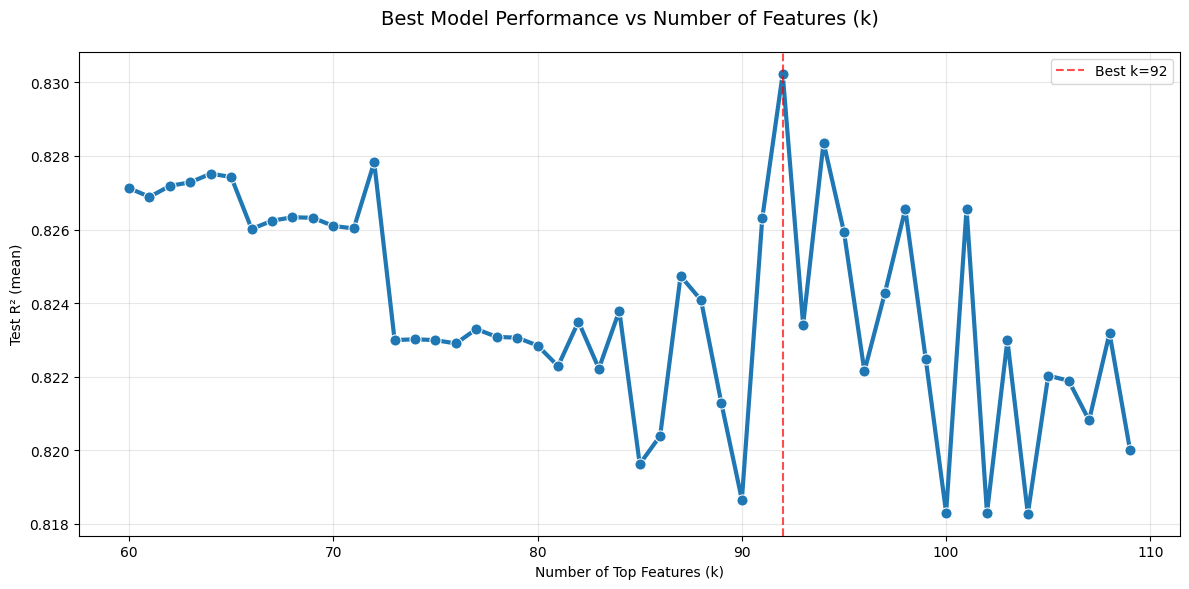

In [349]:
X_selected = pd.DataFrame(
    preprocessor.transform(X),
    columns=preprocessor.get_feature_names_out()
)
results_df, best_config = evaluate_k_features(
    X_selected , y=y,
    selection_result=selection_result,
    k_range=range(60, 110, 1),  # thử 10,15,20,...,100
    test_size=0.2,
    output_csv="best_k_features_temp_hourly.csv"
)

### 3.4 Reverify the best model

In [170]:
def catboost_single_run(
    X_selected,
    y,
    top_features,
    test_size=0.2,
    iterations=300,
    depth=8,
    learning_rate=0.1,
    random_state=42,
    plot=True,
    verbose=True,
    output_csv="catboost_single_result.csv"
):
    """
    CATBOOST + DEGRADATION HOÀN CHỈNH
    - T+5 ở trên → T+1 ở dưới
    - ΔR², % Change, cảnh báo
    - Biểu đồ degradation đẹp như Kaggle
    """
    # === 0. Chuẩn bị y (T+5 ở trên, T+1 ở dưới) ===
    if isinstance(y, (pd.Series, np.ndarray)):
        y = pd.DataFrame(y)
    else:
        y = y.copy()

    n_targets = y.shape[1]
    y = y.iloc[:, ::-1].copy()  # Đảo: T+1 → T+5
    y.columns = [f"T+{n_targets-i}" for i in range(n_targets)]  # T+5, T+4, ..., T+1
    target_names = y.columns.tolist()[::-1]

    if verbose:
        print(f"CATBOOST SINGLE RUN (T+{n_targets} → T+1)")
        print(f"Targets: {target_names}")
        print(f"Input data: {X_selected.shape[0]:,} × {X_selected.shape[1]:,}")

    # === 1. Áp dụng top_features ===
    available_features = [f for f in top_features if f in X_selected.columns]
    missing = len(top_features) - len(available_features)
    if missing and verbose:
        print(f"Warning: {missing} features không tồn tại!")
    X_selected = X_selected[available_features].copy()
    final_n_features = len(available_features)

    if verbose:
        print(f"Features sau chọn: {final_n_features:,}")
        print(f"Top 10: {', '.join(available_features[:10])}{'...' if len(available_features)>10 else ''}")
        print("="*80)

    # === 2. Split ===
    split_idx = int(len(X_selected) * (1 - test_size))
    X_train, X_test = X_selected.iloc[:split_idx], X_selected.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    if verbose:
        print(f"Train: {len(X_train):,} | Test: {len(X_test):,}")

    # === 3. Cat features ===
    cat_features = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

    # === 4. Train CatBoost ===
    model = cb.CatBoostRegressor(
        iterations=iterations,
        depth=depth,
        learning_rate=learning_rate,
        loss_function='MultiRMSE' if n_targets > 1 else 'RMSE',
        random_state=random_state,
        cat_features=cat_features,
        verbose=100 if verbose else False,
        early_stopping_rounds=50,
        od_type='Iter'
    )

    if n_targets == 1:
        model.fit(X_train, y_train.iloc[:, 0], eval_set=(X_test, y_test.iloc[:, 0]), use_best_model=True)
        y_pred = model.predict(X_test).reshape(-1, 1)
    else:
        model.fit(X_train, y_train.values, eval_set=(X_test, y_test.values), use_best_model=True)
        y_pred = model.predict(X_test)

    # === 5. Metrics + DEGRADATION ===
    r2_list = [r2_score(y_test.iloc[:, i], y_pred[:, i]) for i in range(n_targets)]
    mae_list = [mean_absolute_error(y_test.iloc[:, i], y_pred[:, i]) for i in range(n_targets)]
    rmse_list = [np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i])) for i in range(n_targets)]
    r2_mean = np.mean(r2_list)

    # DEGRADATION: T+5 → T+1
    degradation_list = []
    degradation_pct_list = []
    for i in range(1, n_targets):
        deg = r2_list[i] - r2_list[0]
        deg_pct = deg / r2_list[0] if r2_list[0] != 0 else 0
        degradation_list.append(deg)
        degradation_pct_list.append(deg_pct)

    degradation_1_to_5 = r2_list[-1] - r2_list[0] if n_targets > 1 else 0
    mean_daily_change = np.mean(degradation_list) if degradation_list else 0

    # === 6. In kết quả + DEGRADATION ===
    if verbose:
        print(f"\nRESULTS (Test {test_size:.0%}) - {final_n_features:,} features")
        print("-" * 100)
        print(f"{'Day':<8} {'R²':>10} {'MAE':>12} {'RMSE':>12} {'ΔR² vs T+1':>15} {'% Change':>12}")
        print("-" * 100)
        for i, (name, r2, mae, rmse) in enumerate(zip(target_names, r2_list, mae_list, rmse_list)):
            delta = "—" if i == 0 else f"{degradation_list[i-1]:+0.4f}"
            pct = "—" if i == 0 else f"{degradation_pct_list[i-1]:+0.2%}"
            print(f"{name:<8} {r2:10.4f} {mae:12.4f} {rmse:12.4f} {delta:>15} {pct:>12}")
        print("-" * 100)
        print(f"{'MEAN':<8} {r2_mean:10.4f}")
        print("="*100)

    # === 7. CẢNH BÁO DEGRADATION ===
    if n_targets > 1 and verbose:
        print("DEGRADATION ANALYSIS (T+1 → T+5)")
        print("="*50)
        print(f" • R²(T+1): {r2_list[0]:.4f}")
        print(f" • R²(T+5): {r2_list[-1]:.4f}")
        print(f" • ΔR²: {degradation_1_to_5:+.4f} ({degradation_1_to_5/r2_list[0]:+.2%})")
        print(f" • Mean daily change: {mean_daily_change:+.4f}")
        
        if degradation_1_to_5 < 0.02:
            print("   XU HƯỚNG TỐT: Model càng gần ngày càng chính xác!")
        elif degradation_1_to_5 < 0.005:
            print("   ỔN ĐỊNH: Model giữ tốt từ xa đến gần.")
        else:
            print("   CẢNH BÁO: Model giảm mạnh khi dự báo gần → cần cải thiện T+1!")

    # === 8. BIỂU ĐỒ DEGRADATION ===
    if plot and n_targets > 1:
        plt.figure(figsize=(10, 6))
        days = list(range(1, n_targets+1, 1))
        plt.plot(days, r2_list, marker='o', color='navy', linewidth=3, markersize=9, label='R²')
        plt.axhline(y=r2_list[0], color='red', linestyle='--', alpha=0.7, label='T+1 Baseline')
        plt.title(f'CatBoost Performance: T+{n_targets} → T+1\n({final_n_features:,} features)', 
                  fontsize=16, fontweight='bold')
        plt.xlabel('Forecast Horizon (T+)', fontsize=12)
        plt.ylabel('R² Score', fontsize=12)
        plt.xticks(days, [f"T+{d}" for d in days])
        plt.ylim(min(r2_list)*0.95, 1.0)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=11)
        plt.tight_layout()
        plt.show()

    # === 9. SCATTER PLOT ===
    if plot:
        plt.figure(figsize=(15, 5*n_targets))
        for i, target in enumerate(target_names):
            plt.subplot(n_targets, 2, i+1)
            plt.scatter(y_test.iloc[:, i], y_pred[:, i], alpha=0.6, s=50, color='teal')
            min_val = min(y_test.iloc[:, i].min(), y_pred[:, i].min())
            max_val = max(y_test.iloc[:, i].max(), y_pred[:, i].max())
            plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
            plt.xlabel(f'True {target}')
            plt.ylabel(f'Predicted {target}')
            plt.title(f'{target} - R² = {r2_list[i]:.4f}', fontweight='bold')
            plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # === 10. Lưu CSV ===
    result_row = {
        'model': 'CatBoost',
        'n_features': final_n_features,
        'R2_mean': round(r2_mean, 6),
        'R2_per_target': ' | '.join([f"{n}:{r:.4f}" for n, r in zip(target_names, r2_list)]),
        'MAE_mean': round(np.mean(mae_list), 6),
        'RMSE_mean': round(np.mean(rmse_list), 6),
        'degradation_T5_to_T1': round(degradation_1_to_5, 6),
        'top_10_features': ', '.join(available_features[:10]) + ('...' if len(available_features) > 10 else '')
    }
    result_df = pd.DataFrame([result_row])
    result_df.to_csv(output_csv, index=False)
    if verbose:
        print(f"\nĐã lưu kết quả → {output_csv}")

    # === 11. Trả về ===
    return {
        'model': model,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred,
        'metrics': {
            'R2': dict(zip(target_names, r2_list)),
            'MAE': dict(zip(target_names, mae_list)),
            'RMSE': dict(zip(target_names, rmse_list)),
            'R2_mean': r2_mean
        },
        'degradation': {
            'T5_to_T1': degradation_1_to_5,
            'mean_daily_change': mean_daily_change,
            'per_day_r2': r2_list,
            'per_day_delta': ['—'] + degradation_list
        },
        'feature_names': available_features,
        'result_df': result_df
    }

Top selected features:
Index(['month_avg_dew_mean', 'day_avg_feelslike_mean', 'temp_mean',
       'season_avg_solarradiation_mean', 'feelslike_mean',
       'temp_sealevelpressure_interaction', 'temp_trend_24h', 'dayofyear_cos',
       'sealevelpressure_trend_24h', 'rolling_mean_30_solarradiation_mean',
       'rolling_max_5_sealevelpressure_mean',
       'season_avg_sealevelpressure_mean',
       'rolling_max_7_sealevelpressure_mean',
       'rolling_max_21_solarradiation_mean',
       'rolling_mean_4_sealevelpressure_mean',
       'rolling_mean_30_sealevelpressure_mean',
       'rolling_mean_21_solarradiation_mean', 'season_Winter',
       'season_avg_feelslike_mean', 'rolling_max_21_dew_mean',
       'day_avg_sealevelpressure_mean', 'day_avg_temp_mean',
       'rolling_max_14_wind_v_mean', 'rolling_max_14_solarradiation_mean',
       'rolling_max_30_wind_v_mean', 'wind_v_mean', 'wind_u_mean',
       'rolling_mean_2_sealevelpressure_trend_24h',
       'rolling_mean_7_sealevelpressure

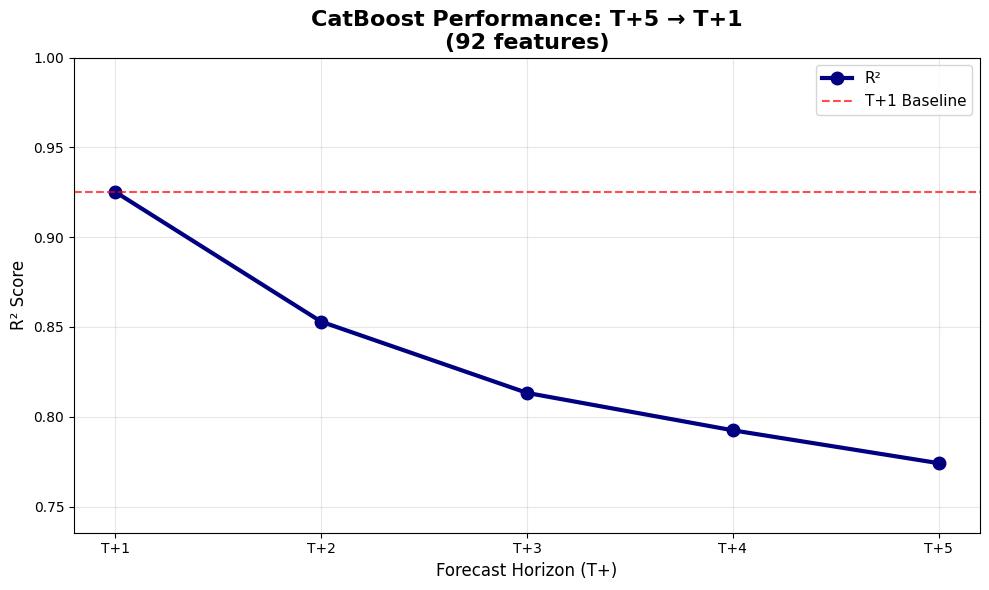

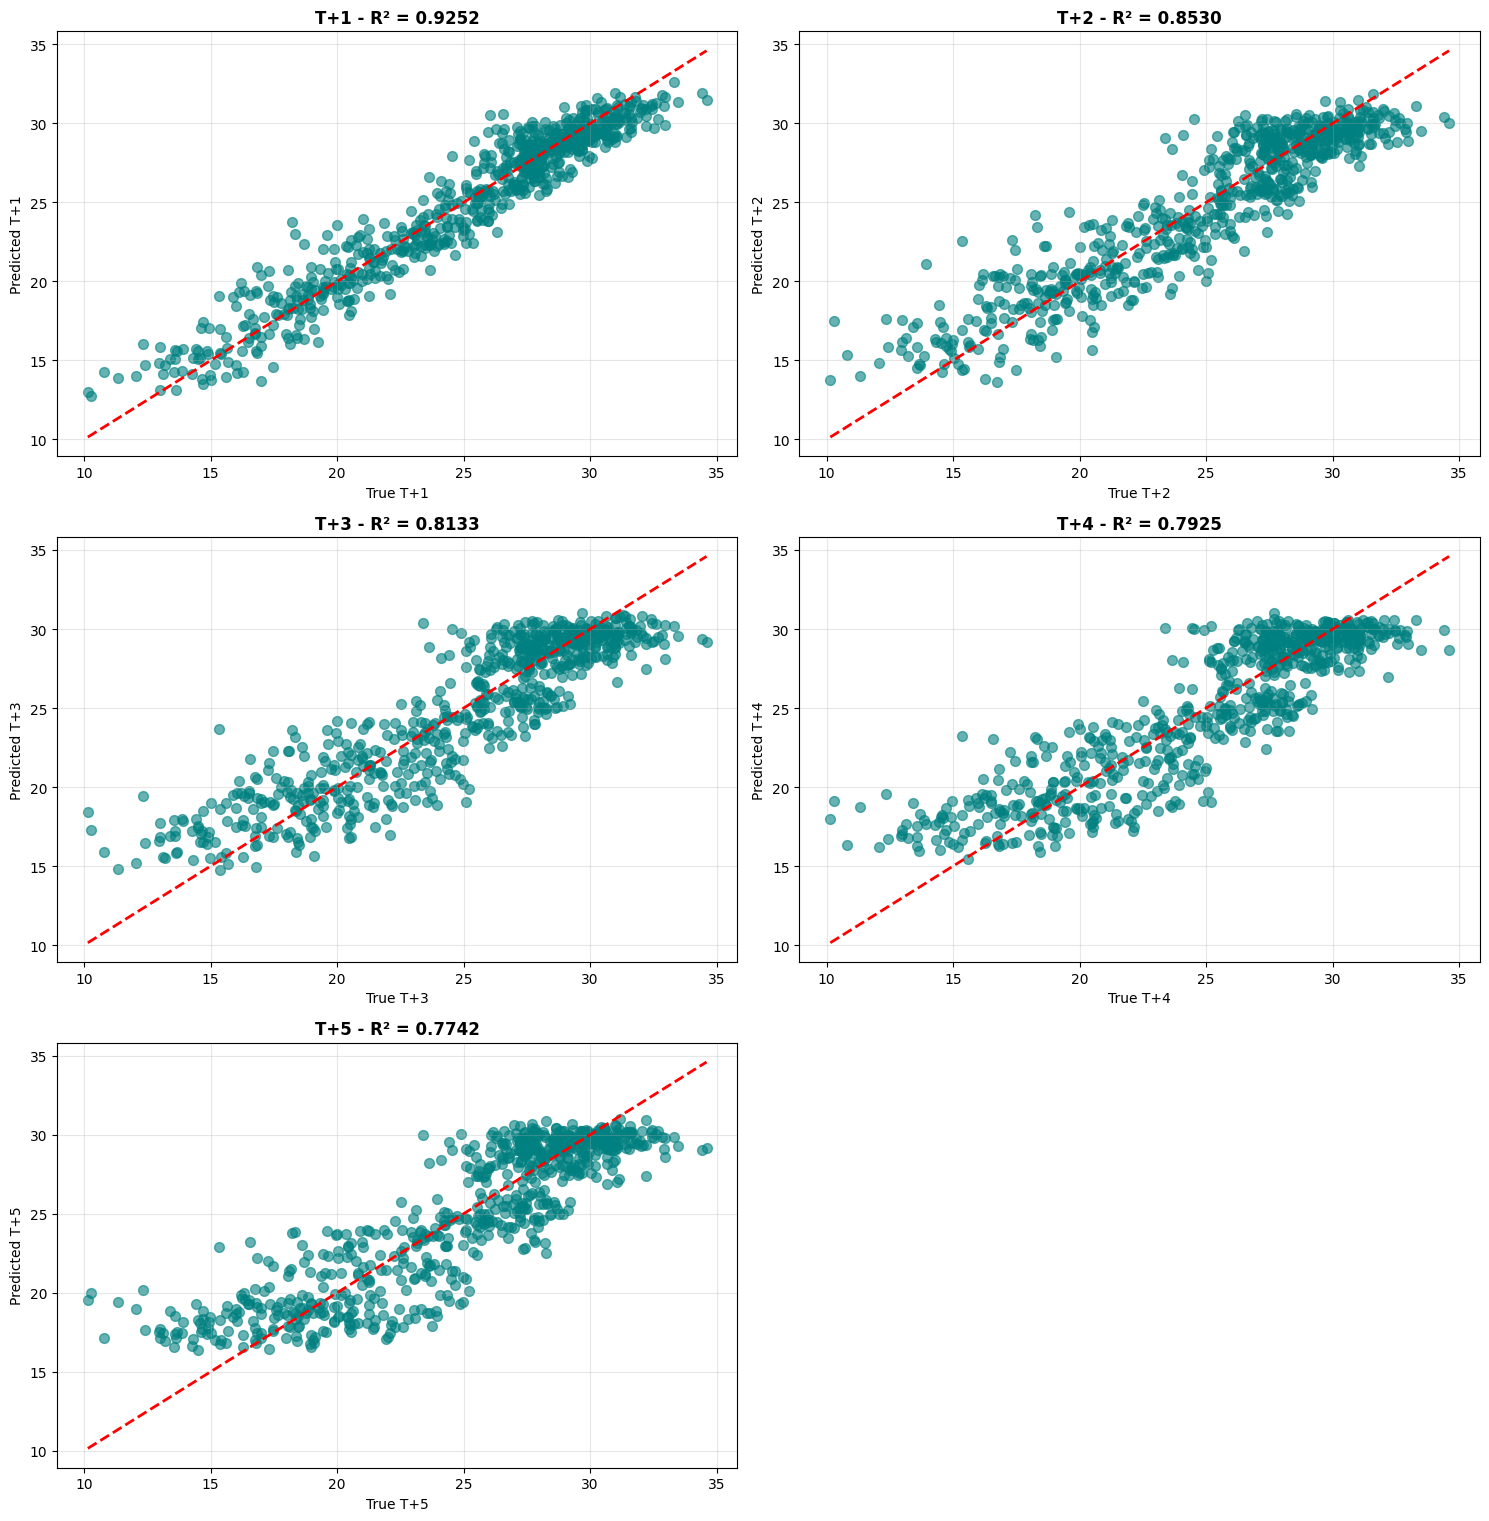


Đã lưu kết quả → catboost_single_result.csv


In [171]:
mean_importance = selection_result['importance_mean']
feature_names = selection_result['feature_names']
k_features = 92

sorted_idx = mean_importance.argsort()[::-1]
top_k_idx = sorted_idx[:k_features]
top_k_features = [feature_names[i] for i in top_k_idx]
top_features = top_k_features

X_selected = pd.DataFrame(
    preprocessor.transform(X),
    columns=preprocessor.get_feature_names_out()
)[top_features]

# Print top k features
print("Top selected features:")
print(X_selected.columns)

result = catboost_single_run(
    X_selected=X_selected,
    y=y,
    top_features=top_features,
    iterations=300,
    depth=8,
    learning_rate=0.1,
    plot=True,
    verbose=True
)

## 3.5 Tunning Hyperparameter

In [197]:
def tuning_catboost_timeseries(
    X, y,
    top_features=None,
    n_trials=100,
    timeout=3600,
    val_ratio=0.2, 
    random_state=42,
    verbose=True
):
    """
    TUNING CATBOOST DÀNH RIÊNG CHO TIMESERIES
    - KHÔNG SHUFFLE
    - Validation = phần cuối cùng (chronological)
    - Early stopping + Optuna + Lưu model
    """
    print(f"TUNING CATBOOST TIMESERIES - {n_trials} trials / {timeout//60} phút")
    print("="*80)
    
    # === 1. Chia dữ liệu THEO THỜI GIAN (train = đầu, val = cuối) ===
    n_samples = len(X)
    split_idx = int(n_samples * (1 - val_ratio))
    
    X_train = X.iloc[:split_idx].copy()
    X_val   = X.iloc[split_idx:].copy()
    y_train = y.iloc[:split_idx].copy()
    y_val   = y.iloc[split_idx:].copy()
    
    if verbose:
        print(f"Train: {len(X_train):,} samples (t=0 → t={split_idx})")
        print(f"Val:   {len(X_val):,} samples (t={split_idx} → t={n_samples})")

    # === 2. Preprocessing (fit chỉ trên train!) ===
    try:
        preprocessor = build_preprocessing_pipeline(X_train)
        preprocessor.fit(X_train)

        X_train_proc = preprocessor.transform(X_train)
        X_val_proc   = preprocessor.transform(X_val)
        feature_names = preprocessor.get_feature_names_out()
    except NameError:
        print("Warning: build_preprocessing_pipeline_catboost không tìm thấy, bỏ qua preprocessing.")
        X_train_proc = X_train.values
        X_val_proc = X_val.values
        feature_names = X_train.columns.tolist()

    top_feature_names = []
    # Áp dụng top_features
    if top_features is not None:
        available = [f for f in top_features if f in feature_names]
        missing = len(top_features) - len(available)
        if missing > 0 and verbose:
            print(f"Warning: {missing}/{len(top_features)} top_features bị thiếu!")
        top_feature_names = available

    # Tạo DataFrame cuối
    X_train_final = pd.DataFrame(X_train_proc, columns=feature_names, index=X_train.index)[top_feature_names]
    X_val_final   = pd.DataFrame(X_val_proc,   columns=feature_names, index=X_val.index)[top_feature_names]
    
    # Cat features
    try:
        all_cat = preprocessor.named_transformers_['cat'].get_feature_names_out()
        cat_features = [f for f in all_cat if f in top_feature_names]
    except (NameError, KeyError):
        cat_features = []
    
    X_train_final[cat_features] = X_train_final[cat_features].astype(int)
    X_val_final[cat_features] = X_val_final[cat_features].astype(int)

    # Chuẩn bị y
    if isinstance(y_train, pd.Series):
        y_train_np = y_train.values
        y_val_np = y_val.values
    else:
        y_train_np = y_train.values
        y_val_np = y_val.values

    # === 3. Optuna Objective ===
    def objective(trial):
        # ... (Phần này giữ nguyên)
        params = {
            'iterations': trial.suggest_int('iterations', 800, 5000),
            'depth': trial.suggest_int('depth', 6, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 3.0, 10.0),
            'border_count': trial.suggest_int('border_count', 128, 254),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
            'random_strength': trial.suggest_float('random_strength', 0.0, 5.0),
            'od_type': 'Iter',
            'early_stopping_rounds': 100,
            'use_best_model': True,
            'verbose': False,
            'random_seed': random_state,
            'loss_function': 'MultiRMSE' if y_train_np.ndim > 1 else 'RMSE',
            'cat_features': cat_features
        }
        
        model = cb.CatBoostRegressor(**params)
        
        model.fit(
            X_train_final, y_train_np,
            eval_set=(X_val_final, y_val_np),
            use_best_model=True,
            verbose=False
        )
        
        pred = model.predict(X_val_final)
        # Tính RMSE (mục tiêu tuning)
        if y_train_np.ndim > 1:
            rmse = np.mean([np.sqrt(mean_squared_error(y_val_np[:, i], pred[:, i])) 
                          for i in range(y_val_np.shape[1])])
        else:
            rmse = np.sqrt(mean_squared_error(y_val_np, pred))
        
        return rmse

    # === 4. CHẠY TUNING ===
    study = optuna.create_study(
        direction='minimize',
        sampler=optuna.samplers.TPESampler(seed=random_state)
    )
    study.optimize(objective, n_trials=n_trials, timeout=timeout, show_progress_bar=True)

    # === 5. In kết quả Tuning Tốt nhất ===
    print(f"\nBEST VAL RMSE (sau {n_trials} trials): {study.best_value:.6f}")
    print("BEST PARAMS:")
    for k, v in study.best_params.items():
        print(f"  {k:20} = {v}")
    
    # --- Bổ sung tính R2 cho mô hình tốt nhất ---
    # ---------------------------------------------
    
    # === 6. Train model cuối cùng (dùng best params) ===
    final_params = study.best_params.copy()
    final_params.update({
        'od_type': 'Iter',
        'early_stopping_rounds': 150,
        'use_best_model': True,
        'verbose': 200,
        'random_seed': random_state,
        'loss_function': 'MultiRMSE' if y_train_np.ndim > 1 else 'RMSE',
        'cat_features': cat_features
    })
    
    final_model = cb.CatBoostRegressor(**final_params)
    print("\n" + "="*80)
    print("BẮT ĐẦU TRAIN MODEL CUỐI VỚI BEST PARAMS:")
    print("="*80)
    final_model.fit(
        X_train_final, y_train_np,
        eval_set=(X_val_final, y_val_np),
        use_best_model=True
    )
    
    # === 7. Tính lại RMSE và Bổ sung R2 trên Validation ===
    final_pred = final_model.predict(X_val_final)
    
    if y_train_np.ndim > 1:
        # Multi-output: Tính trung bình
        final_rmse = np.mean([np.sqrt(mean_squared_error(y_val_np[:, i], final_pred[:, i])) 
                            for i in range(y_val_np.shape[1])])
        final_r2 = np.mean([r2_score(y_val_np[:, i], final_pred[:, i]) 
                          for i in range(y_val_np.shape[1])])
    else:
        # Single-output
        final_rmse = np.sqrt(mean_squared_error(y_val_np, final_pred))
        final_r2 = r2_score(y_val_np, final_pred)

    # === 8. Lưu và In kết quả Cuối cùng ===
    result = {
        'model': final_model,
        'preprocessor': preprocessor,
        'best_params': final_params,
        'best_rmse': final_rmse, # Lưu kết quả RMSE của final model (có thể khác study.best_value)
        'best_r2': final_r2,     # BỔ SUNG R2
        'feature_names': feature_names,
        'val_idx_start': split_idx,
        'study': study
    }
    
    joblib.dump(result, 'BEST_CATBOOST_TIMESERIES_hourly.joblib')
    print(f"\nĐÃ LƯU → **BEST_CATBOOST_TIMESERIES_hourly.joblib**")
    print("-" * 30)
    print(f"🔥 RMSE trên Validation (phần cuối): **{final_rmse:.6f}**")
    print(f"📊 R-squared (R²) trên Validation: **{final_r2:.4f}**") # R2 thường được làm tròn đến 4 chữ số

    return result

In [198]:
# Đảm bảo X, y đã sort theo thời gian!
best_ts = tuning_catboost_timeseries(
    X=X,           # quan trọng: sort theo thời gian
    y=y,
    top_features=top_features,  # có thể None
    n_trials=50,
    timeout=3600,               # 1 tiếng
    val_ratio=0.2
)

TUNING CATBOOST TIMESERIES - 50 trials / 60 phút
Train: 2,828 samples (t=0 → t=2828)
Val:   708 samples (t=2828 → t=3536)
Numerical Features (722): ['temp_mean', 'temp_min', 'temp_max', 'feelslike_mean', 'feelslike_min', 'feelslike_max', 'dew_mean', 'humidity_mean', 'humidity_min', 'humidity_max', 'precip_mean', 'precip_sum', 'precipprob_mean', 'sealevelpressure_mean', 'sealevelpressure_min', 'sealevelpressure_max', 'cloudcover_mean', 'cloudcover_min', 'cloudcover_max', 'visibility_mean', 'solarradiation_mean', 'solarradiation_min', 'solarradiation_max', 'solarenergy_mean', 'uvindex_mean', 'severerisk_mean', 'windgust_max', 'temp_trend_24h', 'sealevelpressure_trend_24h', 'gust_ratio', 'rain_ratio', 'clear_ratio', 'overcast_ratio', 'partly_ratio', 'year', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'dayofyear_sin', 'dayofyear_cos', 'temp_solar_interaction', 'uv_temp_interaction', 'temp_cloudcover_interaction', 'temp_sealevelpressure_interaction', 'effective_solar', 'precip_impact'

[I 2025-11-14 16:33:52,117] A new study created in memory with name: no-name-0ead3bd5-02da-4df8-afe4-c455aa1b39a9
Best trial: 0. Best value: 2.13877:   2%|▏         | 1/50 [01:36<1:19:09, 96.92s/it, 96.92/3600 seconds]

[I 2025-11-14 16:35:29,041] Trial 0 finished with value: 2.138769995790117 and parameters: {'iterations': 2373, 'depth': 10, 'learning_rate': 0.08960785365368121, 'l2_leaf_reg': 7.190609389379256, 'border_count': 147, 'bagging_temperature': 0.15599452033620265, 'random_strength': 0.2904180608409973}. Best is trial 0 with value: 2.138769995790117.


Best trial: 1. Best value: 2.09451:   4%|▍         | 2/50 [03:01<1:11:34, 89.47s/it, 181.17/3600 seconds]

[I 2025-11-14 16:36:53,285] Trial 1 finished with value: 2.0945125288215576 and parameters: {'iterations': 4438, 'depth': 9, 'learning_rate': 0.08341106432362087, 'l2_leaf_reg': 3.144091460070617, 'border_count': 251, 'bagging_temperature': 0.8324426408004217, 'random_strength': 1.0616955533913808}. Best is trial 1 with value: 2.0945125288215576.


Best trial: 2. Best value: 2.06554:   6%|▌         | 3/50 [03:14<42:56, 54.82s/it, 194.77/3600 seconds]  

[I 2025-11-14 16:37:06,885] Trial 2 finished with value: 2.065539222856314 and parameters: {'iterations': 1563, 'depth': 6, 'learning_rate': 0.024878734419814436, 'l2_leaf_reg': 6.673295021425664, 'border_count': 182, 'bagging_temperature': 0.2912291401980419, 'random_strength': 3.0592644736118975}. Best is trial 2 with value: 2.065539222856314.


Best trial: 2. Best value: 2.06554:   8%|▊         | 4/50 [03:50<36:21, 47.43s/it, 230.87/3600 seconds]

[I 2025-11-14 16:37:42,985] Trial 3 finished with value: 2.074311667396887 and parameters: {'iterations': 1386, 'depth': 7, 'learning_rate': 0.029967309097101588, 'l2_leaf_reg': 6.192489889519251, 'border_count': 227, 'bagging_temperature': 0.19967378215835974, 'random_strength': 2.571172192068058}. Best is trial 2 with value: 2.065539222856314.


Best trial: 2. Best value: 2.06554:  10%|█         | 5/50 [03:54<23:46, 31.69s/it, 234.65/3600 seconds]

[I 2025-11-14 16:37:46,771] Trial 4 finished with value: 2.0753129668337835 and parameters: {'iterations': 3288, 'depth': 6, 'learning_rate': 0.061721159481070736, 'l2_leaf_reg': 4.193668865811041, 'border_count': 136, 'bagging_temperature': 0.9488855372533332, 'random_strength': 4.828160165372797}. Best is trial 2 with value: 2.065539222856314.


Best trial: 2. Best value: 2.06554:  12%|█▏        | 6/50 [04:55<30:33, 41.68s/it, 295.72/3600 seconds]

[I 2025-11-14 16:38:47,835] Trial 5 finished with value: 2.068083765491088 and parameters: {'iterations': 4196, 'depth': 7, 'learning_rate': 0.013399060561509796, 'l2_leaf_reg': 7.789631185585098, 'border_count': 183, 'bagging_temperature': 0.12203823484477883, 'random_strength': 2.475884550556351}. Best is trial 2 with value: 2.065539222856314.


Best trial: 2. Best value: 2.06554:  14%|█▍        | 7/50 [09:59<1:31:21, 127.47s/it, 599.81/3600 seconds]

[I 2025-11-14 16:43:51,927] Trial 6 finished with value: 2.1098166421683615 and parameters: {'iterations': 944, 'depth': 10, 'learning_rate': 0.02171103454376615, 'l2_leaf_reg': 7.637655990477874, 'border_count': 167, 'bagging_temperature': 0.5200680211778108, 'random_strength': 2.7335513967163982}. Best is trial 2 with value: 2.065539222856314.


Best trial: 2. Best value: 2.06554:  16%|█▌        | 8/50 [12:18<1:31:48, 131.14s/it, 738.83/3600 seconds]

[I 2025-11-14 16:46:10,942] Trial 7 finished with value: 2.126561817916973 and parameters: {'iterations': 1576, 'depth': 10, 'learning_rate': 0.10196967939171485, 'l2_leaf_reg': 9.576492590949325, 'border_count': 241, 'bagging_temperature': 0.5978999788110851, 'random_strength': 4.609371175115584}. Best is trial 2 with value: 2.065539222856314.


Best trial: 2. Best value: 2.06554:  18%|█▊        | 9/50 [12:33<1:04:38, 94.59s/it, 753.03/3600 seconds] 

[I 2025-11-14 16:46:25,145] Trial 8 finished with value: 2.070961106402002 and parameters: {'iterations': 1171, 'depth': 6, 'learning_rate': 0.011450964268326641, 'l2_leaf_reg': 5.277312315342851, 'border_count': 177, 'bagging_temperature': 0.2713490317738959, 'random_strength': 4.143687545759647}. Best is trial 2 with value: 2.065539222856314.


Best trial: 2. Best value: 2.06554:  20%|██        | 10/50 [13:00<49:15, 73.89s/it, 780.56/3600 seconds] 

[I 2025-11-14 16:46:52,677] Trial 9 finished with value: 2.066528651956168 and parameters: {'iterations': 2298, 'depth': 7, 'learning_rate': 0.05082341959721458, 'l2_leaf_reg': 3.9864695748233387, 'border_count': 229, 'bagging_temperature': 0.07455064367977082, 'random_strength': 4.9344346830025865}. Best is trial 2 with value: 2.065539222856314.


Best trial: 2. Best value: 2.06554:  22%|██▏       | 11/50 [13:28<38:48, 59.70s/it, 808.09/3600 seconds]

[I 2025-11-14 16:47:20,211] Trial 10 finished with value: 2.135860763839153 and parameters: {'iterations': 2957, 'depth': 8, 'learning_rate': 0.18255631599020644, 'l2_leaf_reg': 9.171755156296214, 'border_count': 209, 'bagging_temperature': 0.37239267954698246, 'random_strength': 3.573116210230396}. Best is trial 2 with value: 2.065539222856314.


Best trial: 11. Best value: 2.06458:  24%|██▍       | 12/50 [14:06<33:44, 53.28s/it, 846.71/3600 seconds]

[I 2025-11-14 16:47:58,825] Trial 11 finished with value: 2.064582531333657 and parameters: {'iterations': 2166, 'depth': 7, 'learning_rate': 0.03334320324897118, 'l2_leaf_reg': 5.527865559002203, 'border_count': 206, 'bagging_temperature': 0.038941643902400735, 'random_strength': 3.375716942608492}. Best is trial 11 with value: 2.064582531333657.


Best trial: 11. Best value: 2.06458:  26%|██▌       | 13/50 [14:19<25:14, 40.92s/it, 859.19/3600 seconds]

[I 2025-11-14 16:48:11,309] Trial 12 finished with value: 2.068723071208001 and parameters: {'iterations': 2083, 'depth': 6, 'learning_rate': 0.025399132942428935, 'l2_leaf_reg': 5.778527649030745, 'border_count': 201, 'bagging_temperature': 0.003945015865327091, 'random_strength': 3.483812718053443}. Best is trial 11 with value: 2.064582531333657.


Best trial: 11. Best value: 2.06458:  28%|██▊       | 14/50 [15:02<25:03, 41.76s/it, 902.88/3600 seconds]

[I 2025-11-14 16:48:54,986] Trial 13 finished with value: 2.0943003435415806 and parameters: {'iterations': 3696, 'depth': 8, 'learning_rate': 0.03450381516605957, 'l2_leaf_reg': 5.433434013476078, 'border_count': 160, 'bagging_temperature': 0.3636340619930335, 'random_strength': 1.7139964413315822}. Best is trial 11 with value: 2.064582531333657.


Best trial: 11. Best value: 2.06458:  30%|███       | 15/50 [15:54<26:00, 44.59s/it, 954.03/3600 seconds]

[I 2025-11-14 16:49:46,142] Trial 14 finished with value: 2.0668604914402127 and parameters: {'iterations': 1858, 'depth': 7, 'learning_rate': 0.014628880458508577, 'l2_leaf_reg': 6.618574276810414, 'border_count': 200, 'bagging_temperature': 0.6634064286119826, 'random_strength': 3.380992638411437}. Best is trial 11 with value: 2.064582531333657.


Best trial: 15. Best value: 2.0518:  32%|███▏      | 16/50 [16:09<20:18, 35.83s/it, 969.51/3600 seconds] 

[I 2025-11-14 16:50:01,625] Trial 15 finished with value: 2.05180462626856 and parameters: {'iterations': 2638, 'depth': 6, 'learning_rate': 0.019058553460600987, 'l2_leaf_reg': 8.65646224113015, 'border_count': 218, 'bagging_temperature': 0.33433608718412866, 'random_strength': 1.671291959457139}. Best is trial 15 with value: 2.05180462626856.


Best trial: 15. Best value: 2.0518:  34%|███▍      | 17/50 [17:09<23:39, 43.00s/it, 1029.19/3600 seconds]

[I 2025-11-14 16:51:01,309] Trial 16 finished with value: 2.074219506902659 and parameters: {'iterations': 2732, 'depth': 7, 'learning_rate': 0.017820870531828747, 'l2_leaf_reg': 8.551119574520147, 'border_count': 216, 'bagging_temperature': 0.4509803448642967, 'random_strength': 1.8698885287079228}. Best is trial 15 with value: 2.05180462626856.


Best trial: 15. Best value: 2.0518:  36%|███▌      | 18/50 [18:24<28:09, 52.81s/it, 1104.84/3600 seconds]

[I 2025-11-14 16:52:16,958] Trial 17 finished with value: 2.099203946696376 and parameters: {'iterations': 3490, 'depth': 8, 'learning_rate': 0.039013479873883254, 'l2_leaf_reg': 8.575513341456638, 'border_count': 220, 'bagging_temperature': 0.004740119653089625, 'random_strength': 1.8528119617576009}. Best is trial 15 with value: 2.05180462626856.


Best trial: 15. Best value: 2.0518:  38%|███▊      | 19/50 [24:11<1:12:57, 141.21s/it, 1451.97/3600 seconds]

[I 2025-11-14 16:58:04,081] Trial 18 finished with value: 2.0895948437687726 and parameters: {'iterations': 2731, 'depth': 9, 'learning_rate': 0.010197527708021455, 'l2_leaf_reg': 4.778708655058289, 'border_count': 194, 'bagging_temperature': 0.7269647517880446, 'random_strength': 1.1932282044700624}. Best is trial 15 with value: 2.05180462626856.


Best trial: 15. Best value: 2.0518:  40%|████      | 20/50 [24:31<52:23, 104.80s/it, 1471.91/3600 seconds]  

[I 2025-11-14 16:58:24,022] Trial 19 finished with value: 2.087861427247857 and parameters: {'iterations': 3923, 'depth': 6, 'learning_rate': 0.016917702253579227, 'l2_leaf_reg': 8.382492449327788, 'border_count': 238, 'bagging_temperature': 0.4360998335722802, 'random_strength': 0.4105245223196716}. Best is trial 15 with value: 2.05180462626856.


Best trial: 15. Best value: 2.0518:  42%|████▏     | 21/50 [25:26<43:22, 89.75s/it, 1526.57/3600 seconds] 

[I 2025-11-14 16:59:18,682] Trial 20 finished with value: 2.101924970150886 and parameters: {'iterations': 4911, 'depth': 8, 'learning_rate': 0.04755231346398862, 'l2_leaf_reg': 9.756627625154362, 'border_count': 212, 'bagging_temperature': 0.24349920969427513, 'random_strength': 4.034461543818795}. Best is trial 15 with value: 2.05180462626856.


Best trial: 15. Best value: 2.0518:  44%|████▍     | 22/50 [25:38<30:57, 66.35s/it, 1538.37/3600 seconds]

[I 2025-11-14 16:59:30,484] Trial 21 finished with value: 2.0707818713163886 and parameters: {'iterations': 1810, 'depth': 6, 'learning_rate': 0.022178369703455207, 'l2_leaf_reg': 6.498638679945265, 'border_count': 186, 'bagging_temperature': 0.27318521786765093, 'random_strength': 2.9684566264615566}. Best is trial 15 with value: 2.05180462626856.


Best trial: 15. Best value: 2.0518:  46%|████▌     | 23/50 [25:48<22:12, 49.35s/it, 1548.06/3600 seconds]

[I 2025-11-14 16:59:40,172] Trial 22 finished with value: 2.080432945438026 and parameters: {'iterations': 2439, 'depth': 6, 'learning_rate': 0.02866431416956848, 'l2_leaf_reg': 7.329468519159592, 'border_count': 173, 'bagging_temperature': 0.31696157221463156, 'random_strength': 2.220700096712316}. Best is trial 15 with value: 2.05180462626856.


Best trial: 15. Best value: 2.0518:  48%|████▊     | 24/50 [26:21<19:16, 44.49s/it, 1581.22/3600 seconds]

[I 2025-11-14 17:00:13,338] Trial 23 finished with value: 2.071003185690203 and parameters: {'iterations': 810, 'depth': 7, 'learning_rate': 0.01843601255552456, 'l2_leaf_reg': 6.933235269978792, 'border_count': 202, 'bagging_temperature': 0.5467199080191307, 'random_strength': 3.0468024817538555}. Best is trial 15 with value: 2.05180462626856.


Best trial: 15. Best value: 2.0518:  50%|█████     | 25/50 [26:30<14:08, 33.93s/it, 1590.51/3600 seconds]

[I 2025-11-14 17:00:22,627] Trial 24 finished with value: 2.0760789206895716 and parameters: {'iterations': 3130, 'depth': 6, 'learning_rate': 0.032279634444646745, 'l2_leaf_reg': 5.927914307372076, 'border_count': 190, 'bagging_temperature': 0.09000661674861798, 'random_strength': 1.2967886328090612}. Best is trial 15 with value: 2.05180462626856.


Best trial: 15. Best value: 2.0518:  52%|█████▏    | 26/50 [26:41<10:49, 27.07s/it, 1601.59/3600 seconds]

[I 2025-11-14 17:00:33,687] Trial 25 finished with value: 2.0562784908777845 and parameters: {'iterations': 1652, 'depth': 7, 'learning_rate': 0.06293153894123514, 'l2_leaf_reg': 4.567407291559245, 'border_count': 157, 'bagging_temperature': 0.1892398820810611, 'random_strength': 3.930320162511838}. Best is trial 15 with value: 2.05180462626856.


Best trial: 15. Best value: 2.0518:  54%|█████▍    | 27/50 [26:47<07:54, 20.61s/it, 1607.12/3600 seconds]

[I 2025-11-14 17:00:39,237] Trial 26 finished with value: 2.112516001504435 and parameters: {'iterations': 1979, 'depth': 7, 'learning_rate': 0.13701090055294282, 'l2_leaf_reg': 4.796248987893973, 'border_count': 149, 'bagging_temperature': 0.18475203038890647, 'random_strength': 3.9533130218677357}. Best is trial 15 with value: 2.05180462626856.


Best trial: 15. Best value: 2.0518:  56%|█████▌    | 28/50 [26:57<06:24, 17.47s/it, 1617.27/3600 seconds]

[I 2025-11-14 17:00:49,377] Trial 27 finished with value: 2.0648055506715832 and parameters: {'iterations': 2558, 'depth': 7, 'learning_rate': 0.05886206710037451, 'l2_leaf_reg': 3.827092953721087, 'border_count': 128, 'bagging_temperature': 0.07711550285957436, 'random_strength': 4.388521185679308}. Best is trial 15 with value: 2.05180462626856.


Best trial: 15. Best value: 2.0518:  58%|█████▊    | 29/50 [27:59<10:46, 30.80s/it, 1679.17/3600 seconds]

[I 2025-11-14 17:01:51,288] Trial 28 finished with value: 2.145236786319564 and parameters: {'iterations': 2081, 'depth': 9, 'learning_rate': 0.07080825307626129, 'l2_leaf_reg': 4.441970237702065, 'border_count': 223, 'bagging_temperature': 0.3834183030664818, 'random_strength': 0.8598010372317801}. Best is trial 15 with value: 2.05180462626856.


Best trial: 15. Best value: 2.0518:  60%|██████    | 30/50 [28:11<08:22, 25.13s/it, 1691.05/3600 seconds]

[I 2025-11-14 17:02:03,171] Trial 29 finished with value: 2.067093288368635 and parameters: {'iterations': 2438, 'depth': 7, 'learning_rate': 0.09952514888838646, 'l2_leaf_reg': 3.0645336463083406, 'border_count': 143, 'bagging_temperature': 0.16024059383670175, 'random_strength': 3.7008601942425576}. Best is trial 15 with value: 2.05180462626856.


Best trial: 15. Best value: 2.0518:  62%|██████▏   | 31/50 [28:47<09:00, 28.46s/it, 1727.30/3600 seconds]

[I 2025-11-14 17:02:39,406] Trial 30 finished with value: 2.1396826615414297 and parameters: {'iterations': 1186, 'depth': 8, 'learning_rate': 0.041406947505975886, 'l2_leaf_reg': 5.284914118264754, 'border_count': 154, 'bagging_temperature': 0.2129174320667939, 'random_strength': 0.11002168481556573}. Best is trial 15 with value: 2.05180462626856.


Best trial: 15. Best value: 2.0518:  64%|██████▍   | 32/50 [28:58<07:00, 23.38s/it, 1738.82/3600 seconds]

[I 2025-11-14 17:02:50,932] Trial 31 finished with value: 2.081462682464172 and parameters: {'iterations': 2629, 'depth': 7, 'learning_rate': 0.05874751133190654, 'l2_leaf_reg': 3.728097872069993, 'border_count': 131, 'bagging_temperature': 0.06129729839146368, 'random_strength': 4.447613553196902}. Best is trial 15 with value: 2.05180462626856.


Best trial: 15. Best value: 2.0518:  66%|██████▌   | 33/50 [29:21<06:33, 23.17s/it, 1761.49/3600 seconds]

[I 2025-11-14 17:03:13,608] Trial 32 finished with value: 2.091632492450235 and parameters: {'iterations': 2328, 'depth': 8, 'learning_rate': 0.07915034318644573, 'l2_leaf_reg': 3.5551308817331284, 'border_count': 140, 'bagging_temperature': 0.13325266784830936, 'random_strength': 4.3343543291360636}. Best is trial 15 with value: 2.05180462626856.


Best trial: 15. Best value: 2.0518:  68%|██████▊   | 34/50 [29:32<05:10, 19.39s/it, 1772.07/3600 seconds]

[I 2025-11-14 17:03:24,185] Trial 33 finished with value: 2.066649991525426 and parameters: {'iterations': 1634, 'depth': 7, 'learning_rate': 0.0566687823082544, 'l2_leaf_reg': 3.556584348554761, 'border_count': 129, 'bagging_temperature': 0.05221641602992527, 'random_strength': 3.732225618646547}. Best is trial 15 with value: 2.05180462626856.


Best trial: 15. Best value: 2.0518:  70%|███████   | 35/50 [29:48<04:38, 18.60s/it, 1788.82/3600 seconds]

[I 2025-11-14 17:03:40,936] Trial 34 finished with value: 2.0691343952949453 and parameters: {'iterations': 3014, 'depth': 7, 'learning_rate': 0.04257166861437879, 'l2_leaf_reg': 4.658096699602408, 'border_count': 162, 'bagging_temperature': 0.14208026427331577, 'random_strength': 3.2414999959483817}. Best is trial 15 with value: 2.05180462626856.


Best trial: 15. Best value: 2.0518:  72%|███████▏  | 36/50 [29:52<03:16, 14.00s/it, 1792.11/3600 seconds]

[I 2025-11-14 17:03:44,222] Trial 35 finished with value: 2.07768015276733 and parameters: {'iterations': 2138, 'depth': 6, 'learning_rate': 0.06953263050838522, 'l2_leaf_reg': 4.281516074538487, 'border_count': 151, 'bagging_temperature': 0.21217703897681076, 'random_strength': 4.633247746833858}. Best is trial 15 with value: 2.05180462626856.


Best trial: 15. Best value: 2.0518:  74%|███████▍  | 37/50 [30:03<02:51, 13.23s/it, 1803.52/3600 seconds]

[I 2025-11-14 17:03:55,632] Trial 36 finished with value: 2.0925877493745726 and parameters: {'iterations': 2591, 'depth': 7, 'learning_rate': 0.12905139006669508, 'l2_leaf_reg': 5.049272472618838, 'border_count': 208, 'bagging_temperature': 0.3128374308521592, 'random_strength': 2.330717676181144}. Best is trial 15 with value: 2.05180462626856.


Best trial: 15. Best value: 2.0518:  76%|███████▌  | 38/50 [30:17<02:39, 13.33s/it, 1817.09/3600 seconds]

[I 2025-11-14 17:04:09,204] Trial 37 finished with value: 2.056445750989742 and parameters: {'iterations': 1417, 'depth': 6, 'learning_rate': 0.03716415334556864, 'l2_leaf_reg': 5.879455663820588, 'border_count': 233, 'bagging_temperature': 0.9982835861660029, 'random_strength': 2.787600610872776}. Best is trial 15 with value: 2.05180462626856.


Best trial: 15. Best value: 2.0518:  78%|███████▊  | 39/50 [30:31<02:29, 13.61s/it, 1831.35/3600 seconds]

[I 2025-11-14 17:04:23,469] Trial 38 finished with value: 2.0718427072251346 and parameters: {'iterations': 1330, 'depth': 6, 'learning_rate': 0.03837058367150294, 'l2_leaf_reg': 5.806060211618741, 'border_count': 246, 'bagging_temperature': 0.9077355506470451, 'random_strength': 2.70540810085954}. Best is trial 15 with value: 2.05180462626856.


Best trial: 15. Best value: 2.0518:  80%|████████  | 40/50 [30:44<02:15, 13.52s/it, 1844.66/3600 seconds]

[I 2025-11-14 17:04:36,773] Trial 39 finished with value: 2.0728232126444275 and parameters: {'iterations': 1720, 'depth': 6, 'learning_rate': 0.02445022192818427, 'l2_leaf_reg': 7.196948334254526, 'border_count': 232, 'bagging_temperature': 0.9909523449275297, 'random_strength': 2.0805951262133857}. Best is trial 15 with value: 2.05180462626856.


Best trial: 40. Best value: 2.04469:  82%|████████▏ | 41/50 [31:04<02:19, 15.46s/it, 1864.66/3600 seconds]

[I 2025-11-14 17:04:56,772] Trial 40 finished with value: 2.0446900707456352 and parameters: {'iterations': 1304, 'depth': 6, 'learning_rate': 0.028943559874655654, 'l2_leaf_reg': 6.172914754999881, 'border_count': 251, 'bagging_temperature': 0.8132673519085034, 'random_strength': 1.4786986838347174}. Best is trial 40 with value: 2.0446900707456352.


Best trial: 40. Best value: 2.04469:  84%|████████▍ | 42/50 [31:20<02:05, 15.64s/it, 1880.70/3600 seconds]

[I 2025-11-14 17:05:12,801] Trial 41 finished with value: 2.070717083816208 and parameters: {'iterations': 1427, 'depth': 6, 'learning_rate': 0.029352558313890314, 'l2_leaf_reg': 6.3247497918794435, 'border_count': 253, 'bagging_temperature': 0.8573928303651733, 'random_strength': 1.4720363317710219}. Best is trial 40 with value: 2.0446900707456352.


Best trial: 40. Best value: 2.04469:  86%|████████▌ | 43/50 [31:31<01:38, 14.09s/it, 1891.19/3600 seconds]

[I 2025-11-14 17:05:23,304] Trial 42 finished with value: 2.075669679793026 and parameters: {'iterations': 1046, 'depth': 6, 'learning_rate': 0.03522976414658461, 'l2_leaf_reg': 6.0760025185970115, 'border_count': 235, 'bagging_temperature': 0.7674152324822947, 'random_strength': 0.691986641997921}. Best is trial 40 with value: 2.0446900707456352.


Best trial: 40. Best value: 2.04469:  88%|████████▊ | 44/50 [31:54<01:40, 16.75s/it, 1914.14/3600 seconds]

[I 2025-11-14 17:05:46,260] Trial 43 finished with value: 2.053967184037729 and parameters: {'iterations': 1446, 'depth': 6, 'learning_rate': 0.021146413757530222, 'l2_leaf_reg': 5.568901175789613, 'border_count': 248, 'bagging_temperature': 0.8996997509020584, 'random_strength': 2.8406346663769844}. Best is trial 40 with value: 2.0446900707456352.


Best trial: 40. Best value: 2.04469:  90%|█████████ | 45/50 [32:13<01:27, 17.45s/it, 1933.24/3600 seconds]

[I 2025-11-14 17:06:05,337] Trial 44 finished with value: 2.058473754014732 and parameters: {'iterations': 1403, 'depth': 6, 'learning_rate': 0.02053422606079147, 'l2_leaf_reg': 7.996474206095884, 'border_count': 243, 'bagging_temperature': 0.9222422348986459, 'random_strength': 2.5435193024239546}. Best is trial 40 with value: 2.0446900707456352.


Best trial: 40. Best value: 2.04469:  92%|█████████▏| 46/50 [32:29<01:08, 17.19s/it, 1949.82/3600 seconds]

[I 2025-11-14 17:06:21,939] Trial 45 finished with value: 2.066507650627064 and parameters: {'iterations': 976, 'depth': 6, 'learning_rate': 0.014692545334739788, 'l2_leaf_reg': 5.548927762592985, 'border_count': 247, 'bagging_temperature': 0.8436409341487541, 'random_strength': 1.6129134024381178}. Best is trial 40 with value: 2.0446900707456352.


Best trial: 40. Best value: 2.04469:  94%|█████████▍| 47/50 [32:44<00:49, 16.44s/it, 1964.50/3600 seconds]

[I 2025-11-14 17:06:36,621] Trial 46 finished with value: 2.073871842912102 and parameters: {'iterations': 1240, 'depth': 6, 'learning_rate': 0.024204763349814928, 'l2_leaf_reg': 6.973378785026216, 'border_count': 254, 'bagging_temperature': 0.9691758316307509, 'random_strength': 2.8512480340852093}. Best is trial 40 with value: 2.0446900707456352.


Best trial: 40. Best value: 2.04469:  96%|█████████▌| 48/50 [33:08<00:37, 18.76s/it, 1988.67/3600 seconds]

[I 2025-11-14 17:07:00,788] Trial 47 finished with value: 2.0556381657397234 and parameters: {'iterations': 1553, 'depth': 6, 'learning_rate': 0.013038119699887336, 'l2_leaf_reg': 4.9923923011170315, 'border_count': 226, 'bagging_temperature': 0.7776297924305017, 'random_strength': 2.090643459945019}. Best is trial 40 with value: 2.0446900707456352.


Best trial: 40. Best value: 2.04469:  98%|█████████▊| 49/50 [33:32<00:20, 20.25s/it, 2012.40/3600 seconds]

[I 2025-11-14 17:07:24,506] Trial 48 finished with value: 2.0547156732764216 and parameters: {'iterations': 1539, 'depth': 6, 'learning_rate': 0.011643031198002784, 'l2_leaf_reg': 5.01466416682782, 'border_count': 224, 'bagging_temperature': 0.7378603707965573, 'random_strength': 2.063534614074745}. Best is trial 40 with value: 2.0446900707456352.


Best trial: 40. Best value: 2.04469: 100%|██████████| 50/50 [33:44<00:00, 40.50s/it, 2024.82/3600 seconds]


[I 2025-11-14 17:07:36,938] Trial 49 finished with value: 2.078415357556005 and parameters: {'iterations': 809, 'depth': 6, 'learning_rate': 0.012210250962574084, 'l2_leaf_reg': 5.102756413986472, 'border_count': 223, 'bagging_temperature': 0.7783078213691148, 'random_strength': 2.031518425898657}. Best is trial 40 with value: 2.0446900707456352.

BEST VAL RMSE (sau 50 trials): 2.044690
BEST PARAMS:
  iterations           = 1304
  depth                = 6
  learning_rate        = 0.028943559874655654
  l2_leaf_reg          = 6.172914754999881
  border_count         = 251
  bagging_temperature  = 0.8132673519085034
  random_strength      = 1.4786986838347174

BẮT ĐẦU TRAIN MODEL CUỐI VỚI BEST PARAMS:
0:	learn: 11.2567536	test: 11.2294627	best: 11.2294627 (0)	total: 19.7ms	remaining: 25.7s
200:	learn: 4.3380961	test: 4.8149453	best: 4.8149453 (200)	total: 3.46s	remaining: 19s
400:	learn: 3.7791931	test: 4.7035216	best: 4.7030777 (399)	total: 6.9s	remaining: 15.5s
600:	learn: 3.3529425	te

## 3.5 Evaluate final model

In [210]:
best = joblib.load('BEST_CATBOOST_TIMESERIES_hourly.joblib')

model       = best['model']
preprocessor = best['preprocessor']
cols        = best['feature_names']

print(f"LOAD THÀNH CÔNG! R² = {best['best_r2']:.6f}")
print(f"Sẵn sàng forecast với {len(cols)} features")

LOAD THÀNH CÔNG! R² = 0.835543
Sẵn sàng forecast với 726 features
